Device: cuda
Log-probs shape (time X batch X channels): 128x256x32
Built-in CTC loss fwd 0.0037965774536132812 bwd 0.9368338584899902
Custom CTC loss fwd 0.19373488426208496 bwd 0.1380176544189453
Custom loss matches: True
Grad matches: True
CE grad matches: True


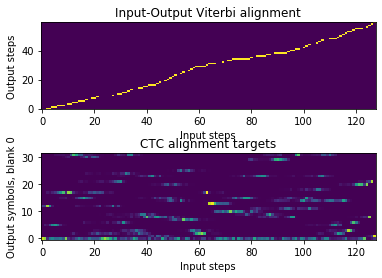

In [1]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 128, 256, 32
t = T // 2 - 4
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

logits = torch.randn(T, B, C, device = device).requires_grad_()
targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')

In [12]:
target_lengths

tensor([60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 60, 60, 

In [10]:
print(t)
print(alignment.size())
a = alignment[:, 0, :target_lengths[0]]
print(a.size())
print(logits.size())

60
torch.Size([128, 256, 61])
torch.Size([128, 60])
torch.Size([128, 256, 32])


In [2]:
logits #= torch.randn(T, B, C, device = device).requires_grad_()
# torch.randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor

tensor([[[-2.9628e-01,  2.6764e+00, -1.4085e-01,  ...,  1.8636e-01,
          -1.5413e+00,  1.3425e+00],
         [ 5.7348e-01,  2.7806e-02,  1.2966e-02,  ..., -8.5268e-01,
           3.5594e-01, -1.3682e+00],
         [-1.4363e+00, -1.5196e+00,  2.2909e-01,  ..., -4.7396e-01,
          -1.3142e+00, -7.8856e-01],
         ...,
         [-1.4285e+00,  2.8120e-01, -1.5915e+00,  ..., -4.0258e-01,
          -2.5593e-01, -3.3626e-02],
         [ 4.7650e-01, -1.7647e+00, -4.2770e-01,  ..., -1.2805e+00,
          -1.0275e+00, -5.2449e-01],
         [ 7.1077e-01, -5.4442e-02, -1.6914e-01,  ...,  1.7871e+00,
           2.7135e+00, -1.6598e-02]],

        [[ 9.2974e-01,  5.7184e-01,  2.0154e-01,  ...,  7.0909e-01,
          -1.4973e+00, -1.4601e+00],
         [-7.4001e-01,  5.3839e-01, -4.7201e-01,  ...,  4.8079e-01,
          -6.8517e-02,  3.3242e-01],
         [ 1.3733e+00, -4.0550e-01, -1.4875e+00,  ...,  6.1299e-01,
          -9.2470e-01, -1.7578e+00],
         ...,
         [-1.1940e+00,  8

In [3]:
targets #= torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
# randint(low=0, high, size, *, generator=None, out=None,

tensor([[12,  5, 17,  ...,  8, 21,  1],
        [ 3, 22,  2,  ..., 15, 20, 26],
        [10, 19, 23,  ..., 28, 18,  1],
        ...,
        [13, 27, 28,  ..., 21, 31, 30],
        [19, 24, 15,  ...,  2, 19, 12],
        [ 4,  5, 21,  ..., 23,  9, 13]], device='cuda:0')

In [13]:
print(targets.size())

torch.Size([256, 60])


In [14]:
a = ce_alignment_targets[:, 0, :]
a.cpu().t()


tensor([[ 8.4674e-01,  7.6278e-01,  1.1277e-01,  ...,  1.0386e-02,
          5.4665e-02,  1.3087e-01],
        [ 5.1707e-06,  7.0781e-07, -5.5879e-07,  ...,  4.8860e-02,
          1.4171e-01,  8.6913e-01],
        [ 3.0920e-07,  4.8801e-07, -3.5390e-07,  ...,  8.3447e-07,
          2.4773e-07,  1.4901e-08],
        ...,
        [ 4.2841e-07,  8.1211e-07, -1.3672e-06,  ...,  2.3097e-07,
          1.2666e-07,  1.4901e-08],
        [ 7.6136e-08,  8.9407e-08, -1.1995e-06,  ...,  7.0781e-08,
          5.6811e-08,  5.5879e-09],
        [ 1.3635e-06,  9.3132e-08, -5.4017e-07,  ...,  1.4156e-07,
          5.4017e-08,  9.3132e-09]])

tensor([[0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])
tensor([[ 8e-01,  8e-01,  1e-01,  4e-01,  4e-01,  3e-01],
        [ 5e-06,  7e-07, -6e-07, -7e-07, -3e-06, -2e-06],
        [ 3e-07,  5e-07, -4e-07, -4e-07, -3e-07, -3e-07],
        [ 2e-07,  1e-07, -2e-07, -2e-06, -7e-07, -2e-06],
        [ 5e-07,  2e-07, -6e-07, -6e-07, -3e-06, -4e-06],
        [ 3e-07,  7e-02,  4e-02,  2e-01,  4e-01,  5e-01],
        [ 8e-08,  1e-07, -4e-07, -1e-06, -9e-07, -1e-06],
        [ 4e-06,  5e-07, -2e-07, -7e-08, -1e-06, -6e-07],
        [ 3e-07,  7e-07, -1e-07, -9e-07, -3e-07, -7e-07],
        [ 2e-08,  5e-07, -3e-06, -2e-06, -5e-06, -1e-06],
        [ 2e-07,  2e-07, -5e-07, -7e-07, -6e-07, -3e-07],
        [ 7e-07,  6e-07, -8e-07, -2e-07, -2e-07, -1e-06],
        [ 2e-01,  2e-01,  8e-01,  4e-01,  5e-02,  2e-03],
        [ 3e-07,  9e-08, -6e-07, -1e-07, -3e-07, -9e-07]])
tensor([12,  3, 10,  7, 28], device='cuda:0')


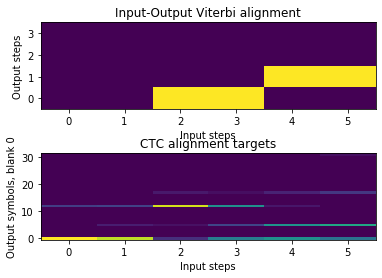

In [31]:
alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu()[:4,:6], origin = 'lower', aspect = 'auto')
print(a.t().cpu()[:4,:6])
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu()[:,:6], origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=0)
print(a.t().cpu()[:14,:6])
print(targets[:5,0])

In [ ]:
Test a small set

In [32]:
probs_seq1 = [[
            0.06390443, 0.21124858, 0.27323887, 0.06870235, 0.0361254,
            0.18184413, 0.16493624
        ], [
            0.03309247, 0.22866108, 0.24390638, 0.09699597, 0.31895462,
            0.0094893, 0.06890021
        ], [
            0.218104, 0.19992557, 0.18245131, 0.08503348, 0.14903535,
            0.08424043, 0.08120984
        ], [
            0.12094152, 0.19162472, 0.01473646, 0.28045061, 0.24246305,
            0.05206269, 0.09772094
        ], [
            0.1333387, 0.00550838, 0.00301669, 0.21745861, 0.20803985,
            0.41317442, 0.01946335
        ], [
            0.16468227, 0.1980699, 0.1906545, 0.18963251, 0.19860937,
            0.04377724, 0.01457421
        ]]

In [57]:
print(torch.Tensor(probs_seq1).size())
print(torch.reshape(torch.Tensor(probs_seq1), (6,1,7)).size())

torch.Size([6, 7])
torch.Size([6, 1, 7])


In [36]:
logits.size()

torch.Size([6, 1, 7])

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.0006482601165771484 bwd 0.0009298324584960938
Custom CTC loss fwd 0.003294706344604492 bwd 0.00738072395324707
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[ 9.10e-02,  4.07e-02,  3.12e-01,  2.21e-01,  5.52e-02,  9.16e-02],
        [-1.39e-16,  2.78e-17,  1.11e-16,  0.00e+00, -8.67e-19, -1.11e-16],
        [ 9.09e-01,  4.64e-01,  1.25e-01,  0.00e+00, -4.34e-19, -1.11e-16],
        [-5.55e-17,  0.00e+00,  4.16e-17,  0.00e+00, -2.78e-17, -1.11e-16],
        [-2.78e-17,  4.96e-01,  4.27e-01,  5.72e-01,  1.67e-01,  9.08e-01],
        [-1.39e-16,  0.00e+00,  1.36e-01,  2.07e-01,  7.78e-01, -2.78e-17],
        [-1.11e-16,  0.00e+00,  4.16e-17,  0.00e+00, -3.47e-18, -8.67e-18]],
       dtype=torch.float64)
tensor([2], devic

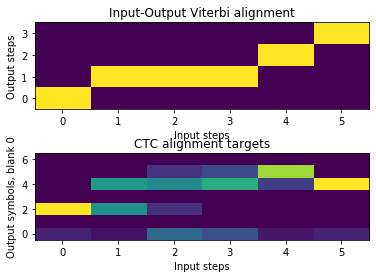

In [62]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 4
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([2,4,5,4]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
print(a.t().cpu())
print(targets[:,0])
print(logits)

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.0009300708770751953 bwd 0.0009093284606933594
Custom CTC loss fwd 0.0031309127807617188 bwd 0.007601261138916016
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[-6.9e-17, -5.6e-17,  1.0e+00, -1.4e-16, -8.3e-17, -1.1e-16],
        [-2.2e-16, -3.9e-16, -2.2e-16, -2.2e-16, -3.5e-18, -1.1e-16],
        [ 1.0e+00, -4.2e-16, -1.9e-16, -1.6e-17, -2.2e-18, -1.1e-16],
        [-6.9e-17, -1.7e-16, -9.7e-17,  1.0e+00, -1.4e-16, -1.1e-16],
        [-4.2e-17,  1.0e+00, -1.7e-16, -2.8e-16, -1.4e-16,  1.0e+00],
        [-1.9e-16, -1.6e-17, -9.7e-17, -5.6e-17,  1.0e+00, -2.8e-17],
        [-1.9e-16, -1.2e-16, -8.3e-17, -1.1e-16, -1.4e-17, -8.7e-18]],
       dtype=torc

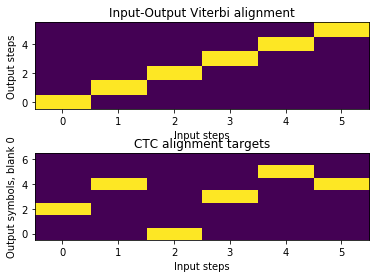

In [63]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 6
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([2,4,0,3,5,4]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=1)
print(a.t().cpu())
print(targets[:,0])
print(logits)

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.0009298324584960938 bwd 0.0007643699645996094
Custom CTC loss fwd 0.003148794174194336 bwd 0.007570981979370117
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[ 1.16e-01,  5.27e-02,  2.86e-01,  3.25e-01,  9.30e-01,  1.06e-01],
        [ 1.94e-16,  3.54e-01,  4.98e-01,  6.40e-01,  3.31e-02, -1.39e-16],
        [ 8.84e-01,  5.94e-01,  2.16e-01,  3.52e-02,  3.71e-02,  8.94e-01],
        [ 6.94e-17,  6.94e-17,  4.16e-17, -5.55e-17, -1.39e-16, -1.39e-16],
        [ 3.47e-17,  2.22e-16,  8.33e-17, -2.78e-17, -1.39e-16, -1.39e-16],
        [ 1.67e-16,  6.94e-18,  4.16e-17, -6.94e-18, -2.78e-16, -2.78e-17],
        [ 1.67e-16,  5.55e-17,  4.16e-17, -1.39e-17, -1.39e-17, -1.04e-17]],
       dtype=torch.float64)
tensor([2], device='cuda:0')
tensor([[[-2.75, -1.5

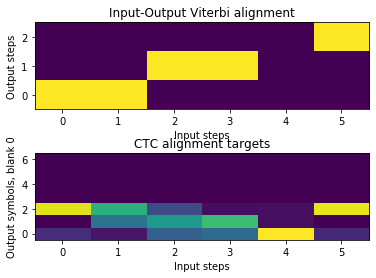

In [64]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 3
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([2,1,2]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
print(a.t().cpu())
print(targets[:,0])
print(logits)

In [ ]:
Test abc example
abc-1

In [68]:
probs_seq1 = [[
            0.06390443, 0.42124858, 0.27323887, 0.06870235, 0.0361254,
            0.18184413, 0.16493624
        ], [
            0.03309247, 0.42866108, 0.24390638, 0.09699597, 0.31895462,
            0.0094893, 0.06890021
        ], [
            0.218104, 0.49992557, 0.18245131, 0.08503348, 0.14903535,
            0.08424043, 0.08120984
        ], [
            0.12094152, 0.41162472, 0.01473646, 0.28045061, 0.24246305,
            0.05206269, 0.09772094
        ], [
            0.1333387, 0.40550838, 0.00301669, 0.21745861, 0.20803985,
            0.41317442, 0.01946335
        ], [
            0.16468227, 0.4180699, 0.1906545, 0.18963251, 0.19860937,
            0.04377724, 0.01457421
        ]]

In [75]:
print(torch.as_tensor(probs_seq1))

tensor([[0.06, 0.42, 0.27, 0.07, 0.04, 0.18, 0.16],
        [0.03, 0.43, 0.24, 0.10, 0.32, 0.01, 0.07],
        [0.22, 0.50, 0.18, 0.09, 0.15, 0.08, 0.08],
        [0.12, 0.41, 0.01, 0.28, 0.24, 0.05, 0.10],
        [0.13, 0.41, 0.00, 0.22, 0.21, 0.41, 0.02],
        [0.16, 0.42, 0.19, 0.19, 0.20, 0.04, 0.01]])


In [71]:
logits

tensor([[[-2.75, -0.86, -1.30, -2.68, -3.32, -1.70, -1.80]],

        [[-3.41, -0.85, -1.41, -2.33, -1.14, -4.66, -2.68]],

        [[-1.52, -0.69, -1.70, -2.46, -1.90, -2.47, -2.51]],

        [[-2.11, -0.89, -4.22, -1.27, -1.42, -2.96, -2.33]],

        [[-2.01, -0.90, -5.80, -1.53, -1.57, -0.88, -3.94]],

        [[-1.80, -0.87, -1.66, -1.66, -1.62, -3.13, -4.23]]], device='cuda:0',
       dtype=torch.float64, requires_grad=True)

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.0003521442413330078 bwd 0.0011229515075683594
Custom CTC loss fwd 0.0035028457641601562 bwd 0.007745504379272461
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0.]], dtype=torch.float64)
tensor([[6.27e-02, 2.89e-02, 2.50e-01, 2.68e-01, 2.33e-01, 5.01e-01],
        [9.37e-01, 4.72e-01, 4.90e-02, 6.37e-03, 5.55e-17, 1.11e-16],
        [2.50e-16, 4.99e-01, 6.33e-01, 8.27e-02, 9.55e-03, 5.55e-17],
        [6.94e-17, 2.78e-17, 6.81e-02, 6.43e-01, 7.58e-01, 4.99e-01],
        [3.47e-17, 1.11e-16, 1.53e-16, 8.33e-17, 2.78e-17, 5.55e-17],
        [1.67e-16, 3.47e-18, 8.33e-17, 1.39e-17, 5.55e-17, 6.94e-18],
        [1.67e-16, 2.08e-17, 7.63e-17, 2.78e-17, 1.73e-18, 3.47e-18]],
       dtype=torch.float64)
tensor([1], device='cuda:0')
tensor([[[-2.75, -0.86, -1.30, -2.68, -3.32, -1.70, -1.80]],



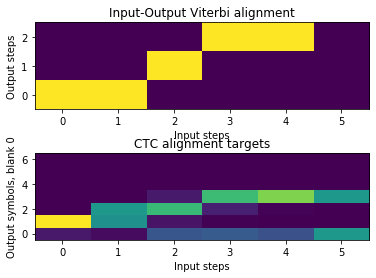

In [69]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 3
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([1,2,3]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
print(a.t().cpu())
print(targets[:,0])
print(logits)

In [ ]:
test abc-2

In [81]:
probs_seq1 = [[
            0.06390443, 0.42124858, 0.27323887, 0.06870235, 0.0361254,
            0.18184413, 0.16493624
        ], [
            0.03309247, 0.42866108, 0.24390638, 0.09699597, 0.31895462,
            0.0094893, 0.06890021
        ], [
            0.218104, 0.49992557, 0.18245131, 0.08503348, 0.14903535,
            0.08424043, 0.08120984
        ], [
            0.12094152, 0.41162472, 0.01473646, 0.28045061, 0.24246305,
            0.05206269, 0.09772094
        ], [
            0.5333387, 0.40550838, 0.00301669, 0.21745861, 0.20803985,
            0.41317442, 0.01946335
        ], [
            0.16468227, 0.4180699, 0.1906545, 0.53963251, 0.19860937,
            0.04377724, 0.01457421
        ]]

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.00041484832763671875 bwd 0.0006978511810302734
Custom CTC loss fwd 0.002694845199584961 bwd 0.006189823150634766
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1.]], dtype=torch.float64)
tensor([[ 6.53e-02,  2.93e-02,  2.52e-01,  3.72e-01,  5.03e-01,  3.07e-01],
        [ 9.35e-01,  4.91e-01,  6.44e-02,  5.87e-03,  0.00e+00, -1.11e-16],
        [-1.94e-16,  4.80e-01,  6.27e-01,  1.15e-01,  8.80e-03, -5.55e-17],
        [-4.86e-17, -4.16e-17,  5.67e-02,  5.07e-01,  4.88e-01,  6.93e-01],
        [-2.43e-17, -1.67e-16,  0.00e+00,  5.55e-17,  0.00e+00, -5.55e-17],
        [-1.39e-16, -5.20e-18,  0.00e+00,  1.39e-17,  0.00e+00, -1.39e-17],
        [-1.11e-16, -3.47e-17,  0.00e+00,  2.78e-17,  0.00e+00, -3.47e-18]],
       dtype=torch.float64)
tensor([1], device='cuda:0')
tensor([[[-2.75, -0.

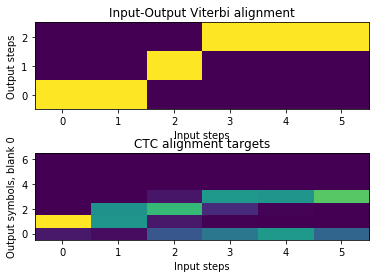

In [82]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 3
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([1,2,3]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
print(a.t().cpu())
print(targets[:,0])
print(logits)

In [ ]:
test abc-3

Device: cuda
Log-probs shape (time X batch X channels): 6x1x7
Built-in CTC loss fwd 0.00091552734375 bwd 0.0007872581481933594
Custom CTC loss fwd 0.0030519962310791016 bwd 0.007417201995849609
Custom loss matches: True
Grad matches: True
CE grad matches: True
tensor([[1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]], dtype=torch.float64)
tensor([[ 6.58e-02,  2.94e-02,  2.52e-01,  4.03e-01,  6.40e-01,  3.27e-01],
        [ 9.34e-01,  4.94e-01,  6.69e-02,  4.26e-03,  1.11e-16,  5.55e-17],
        [ 8.33e-17,  4.77e-01,  6.26e-01,  1.24e-01,  6.39e-03,  1.39e-17],
        [ 2.08e-17,  4.16e-17,  5.51e-02,  4.69e-01,  3.54e-01,  6.73e-01],
        [ 1.04e-17,  1.11e-16, -4.16e-17, -2.78e-17,  5.55e-17,  2.78e-17],
        [ 5.55e-17,  3.47e-18, -2.78e-17, -6.94e-18,  1.11e-16,  3.47e-18],
        [ 5.55e-17,  2.78e-17, -2.08e-17, -1.39e-17,  5.20e-18,  1.73e-18]],
       dtype=torch.float64)
tensor([1], device='cuda:0')
tensor([[[-2.75, -0.86, -

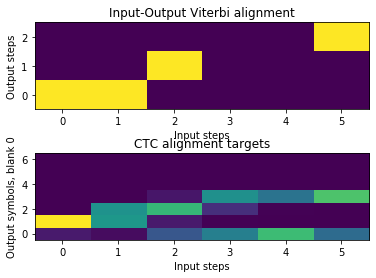

In [84]:
probs_seq1 = [[
            0.06390443, 0.42124858, 0.27323887, 0.06870235, 0.0361254,
            0.18184413, 0.16493624
        ], [
            0.03309247, 0.42866108, 0.24390638, 0.09699597, 0.31895462,
            0.0094893, 0.06890021
        ], [
            0.218104, 0.49992557, 0.18245131, 0.08503348, 0.14903535,
            0.08424043, 0.08120984
        ], [
            0.12094152, 0.41162472, 0.01473646, 0.28045061, 0.24246305,
            0.05206269, 0.09772094
        ], [
            0.9333387, 0.40550838, 0.00301669, 0.21745861, 0.20803985,
            0.41317442, 0.01946335
        ], [
            0.16468227, 0.4180699, 0.1906545, 0.53963251, 0.19860937,
            0.04377724, 0.01457421
        ]]
import time
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import ctc

T, B, C = 6, 1, 7
t = 3
blank = 0
device = 'cuda'
seed = 1
atol = 1e-3
for set_seed in [torch.manual_seed] + ([torch.cuda.manual_seed_all] if device == 'cuda' else []):
	set_seed(seed)
tictoc = lambda: (device == 'cuda' and torch.cuda.synchronize()) or time.time()

# logits = torch.randn(T, B, C, device = device).requires_grad_()
import numpy
logits = torch.reshape(torch.as_tensor(numpy.array(numpy.log(probs_seq1)),device = device), (6,1,7)).requires_grad_()

# targets = torch.randint(blank + 1, C, (B, t), dtype = torch.long, device = device)
targets = torch.reshape(torch.as_tensor(numpy.array([1,2,3]), dtype = torch.long, device = device), (B, t))



input_lengths = torch.full((B,), T, dtype = torch.long, device = device)
target_lengths = torch.full((B,), t, dtype = torch.long, device = device)
log_probs = logits.log_softmax(dim = -1)

print('Device:', device)
print('Log-probs shape (time X batch X channels):', 'x'.join(map(str, log_probs.shape)))

tic = tictoc()
builtin_ctc = F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
builtin_ctc_grad, = torch.autograd.grad(builtin_ctc.sum(), logits, retain_graph = True)
print('Built-in CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

tic = tictoc()
custom_ctc = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none')
toc = tictoc()
custom_ctc_grad, = torch.autograd.grad(custom_ctc.sum(), logits, retain_graph = True)
print('Custom CTC loss', 'fwd', toc - tic, 'bwd', tictoc() - toc)

ce_alignment_targets = ctc.ctc_alignment_targets(log_probs, targets, input_lengths, target_lengths, blank = 0)
ce_ctc = -ce_alignment_targets * log_probs
ce_ctc_grad, = torch.autograd.grad(ce_ctc.sum(), logits, retain_graph = True)

print('Custom loss matches:', torch.allclose(builtin_ctc, custom_ctc, atol = atol))
print('Grad matches:', torch.allclose(builtin_ctc_grad, custom_ctc_grad, atol = atol))
print('CE grad matches:', torch.allclose(builtin_ctc_grad, ce_ctc_grad, atol = atol))

alignment = ctc.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank = 0, reduction = 'none', alignment = True)
a = alignment[:, 0, :target_lengths[0]]
print(a.t().cpu())
plt.subplot(211)
plt.title('Input-Output Viterbi alignment')
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel('Output steps')
plt.subplot(212)
plt.title('CTC alignment targets')
a = ce_alignment_targets[:, 0, :]
plt.imshow(a.t().cpu(), origin = 'lower', aspect = 'auto')
plt.xlabel('Input steps')
plt.ylabel(f'Output symbols, blank {blank}')
plt.subplots_adjust(hspace = 0.5)
plt.savefig('alignment.png')
torch.set_printoptions(precision=2)
print(a.t().cpu())
print(targets[:,0])
print(logits)